In [38]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
import qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import *

from qiskit.providers.ibmq import least_busy
IBMQ.save_account('9ff1c619f266188a92c5a0444fed8fd525e7889a3e4aee6f0d75e7d94c71ba57dae5e0a3258a28365e8645e1e4bf9c8983d34cfec777358a2c7fa08ee5b6a48b', overwrite=True)

# import basic plot tools
from qiskit.visualization import plot_histogram

# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

from qiskit.providers.aer import AerSimulator
import random
import time

In [39]:
conditions = [[0,1,2,5], [0,1,2,6], [0,1,3,6], [0,1,3,4], [0,1,5,6], [0,1,4,7], [0,5,6,7], [0,4,5,7], [0,3,4,5], [0,3,6,7], [0,2,3,7], [0,2,3,5], [3,4,6,7], [3,4,5,6], [2,5,6,7], [2,4,5,7], [2,3,5,6], [2,3,4,7], [1,4,6,7], [1,4,5,6], [1,2,4,5], [1,2,6,7], [1,2,3,4], [1,2,3,6]]



Number of elements in the list:  24


In [40]:
conditions = [[0,1,2,5], [0,1,2,6], [0,1,3,6], [0,1,3,4], [0,1,5,6], [0,1,4,7], [0,5,6,7], [0,4,5,7], [0,3,4,5], [0,3,6,7], [0,2,3,7], [0,2,3,5], [3,4,6,7], [3,4,5,6], [2,5,6,7], [2,4,5,7], [2,3,5,6], [2,3,4,7], [1,4,6,7], [1,4,5,6], [1,2,4,5], [1,2,6,7], [1,2,3,4], [1,2,3,6]]



in_qubits = QuantumRegister(8, name = 'in')
out_qubit = QuantumRegister(1, name = 'out')
qc = QuantumCircuit(in_qubits, out_qubit)

qc.mct(conditions[0], out_qubit)

qc.draw()

in_0: ──■──
        │  
in_1: ──■──
        │  
in_2: ──■──
        │  
in_3: ──┼──
        │  
in_4: ──┼──
        │  
in_5: ──■──
        │  
in_6: ──┼──
        │  
in_7: ──┼──
      ┌─┴─┐
 out: ┤ X ├
      └───┘

In [41]:
conditions = [[0,1,2,5], [0,1,2,6], [0,1,3,6], [0,1,3,4], [0,1,5,6], [0,1,4,7], [0,5,6,7], [0,4,5,7], [0,3,4,5], [0,3,6,7], [0,2,3,7], [0,2,3,5], [3,4,6,7], [3,4,5,6], [2,5,6,7], [2,4,5,7], [2,3,5,6], [2,3,4,7], [1,4,6,7], [1,4,5,6], [1,2,4,5], [1,2,6,7], [1,2,3,4], [1,2,3,6]]



def sudoku_oracle(qc, conditions, in_qubits, out_qubit, final_qubit):
    for i in range(24):
        qc.mct(conditions[i], out_qubit)
        
    qc.mct(out_qubit, final_qubit)
        
    for i in range(24):
        qc.mct(conditions[i], out_qubit)
    

In [42]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [54]:
in_qubits = QuantumRegister(8, name = 'in')
out_qubit = QuantumRegister(1, name = 'out')
final_qubit = QuantumRegister(1, name = 'final')
cbits = ClassicalRegister(8, name='cbits')
qc = QuantumCircuit(in_qubits, out_qubit, final_qubit, cbits)

qc.initialize([1, -1]/np.sqrt(2), out_qubit)
# Initialize qubits in state |s>
qc.h(in_qubits)
qc.barrier()  # for visual separation
#first iteration
sudoku_oracle(qc, conditions, in_qubits, out_qubit, final_qubit)
qc.barrier()
qc.append(diffuser(8), [0,1,2,3,4,5,6,7])
#second iteration
sudoku_oracle(qc, conditions, in_qubits, out_qubit, final_qubit)
qc.barrier()
qc.append(diffuser(8), [0,1,2,3,4,5,6,7])


display(qc.draw())
qc.measure(in_qubits, cbits)

┌───┐               ░                                    »
   in_0: ─────────────┤ H ├───────────────░───■────■────■────■────■────■────■──»
                      ├───┤               ░   │    │    │    │    │    │    │  »
   in_1: ─────────────┤ H ├───────────────░───■────■────■────■────■────■────┼──»
                      ├───┤               ░   │    │    │    │    │    │    │  »
   in_2: ─────────────┤ H ├───────────────░───■────■────┼────┼────┼────┼────┼──»
                      ├───┤               ░   │    │    │    │    │    │    │  »
   in_3: ─────────────┤ H ├───────────────░───┼────┼────■────■────┼────┼────┼──»
                      ├───┤               ░   │    │    │    │    │    │    │  »
   in_4: ─────────────┤ H ├───────────────░───┼────┼────┼────■────┼────■────┼──»
                      ├───┤               ░   │    │    │    │    │    │    │  »
   in_5: ─────────────┤ H ├───────────────░───■────┼────┼────┼────■────┼────■──»
                      ├───┤               ░   │    │    │    │    │    │    │  »
   in_6: ─────────────┤ H ├───────────────░───┼────■────■────┼────■────┼────■──»
                      ├───┤               ░   │    │    │    │    │    │    │  »
   in_7: ─────────────┤ H ├───────────────░───┼────┼────┼────┼────┼────■────■──»
         ┌────────────┴───┴─────────────┐ ░ ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐»
    out: ┤ Initialize(0.70711,-0.70711) ├─░─┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├»
         └──────────────────────────────┘ ░ └───┘└───┘└───┘└───┘└───┘└───┘└───┘»
  final: ─────────────────────────────────░────────────────────────────────────»
                                          ░                                    »
cbits: 8/══════════════════════════════════════════════════════════════════════»
                                                                               »
«                                                                          »
«   in_0: ──■────■────■────■────■──────────────────────────────────────────»
«           │    │    │    │    │                                          »
«   in_1: ──┼────┼────┼────┼────┼──────────────────────────────────■────■──»
«           │    │    │    │    │                                  │    │  »
«   in_2: ──┼────┼────┼────■────■──────────────■────■────■────■────┼────┼──»
«           │    │    │    │    │              │    │    │    │    │    │  »
«   in_3: ──┼────■────■────■────■────■────■────┼────┼────■────■────┼────┼──»
«           │    │    │    │    │    │    │    │    │    │    │    │    │  »
«   in_4: ──■────■────┼────┼────┼────■────■────┼────■────┼────■────■────■──»
«           │    │    │    │    │    │    │    │    │    │    │    │    │  »
«   in_5: ──■────■────┼────┼────■────┼────■────■────■────■────┼────┼────■──»
«           │    │    │    │    │    │    │    │    │    │    │    │    │  »
«   in_6: ──┼────┼────■────┼────┼────■────■────■────┼────■────┼────■────■──»
«           │    │    │    │    │    │    │    │    │    │    │    │    │  »
«   in_7: ──■────┼────■────■────┼────■────┼────■────■────┼────■────■────┼──»
«         ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐»
«    out: ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├»
«         └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
«  final: ─────────────────────────────────────────────────────────────────»
«                                                                          »
«cbits: 8/═════════════════════════════════════════════════════════════════»
«                                                                          »
«                                                                          »
«   in_0: ───────────────────────────■────■────■────■────■────■────■────■──»
«                                    │    │    │    │    │    │    │    │  »
«   in_1: ──■────■────■────■─────────■────■────■────■────■────■────┼────┼──»
«           │    │    │    │         │    │    │    │    │    │    │    │  »
«  

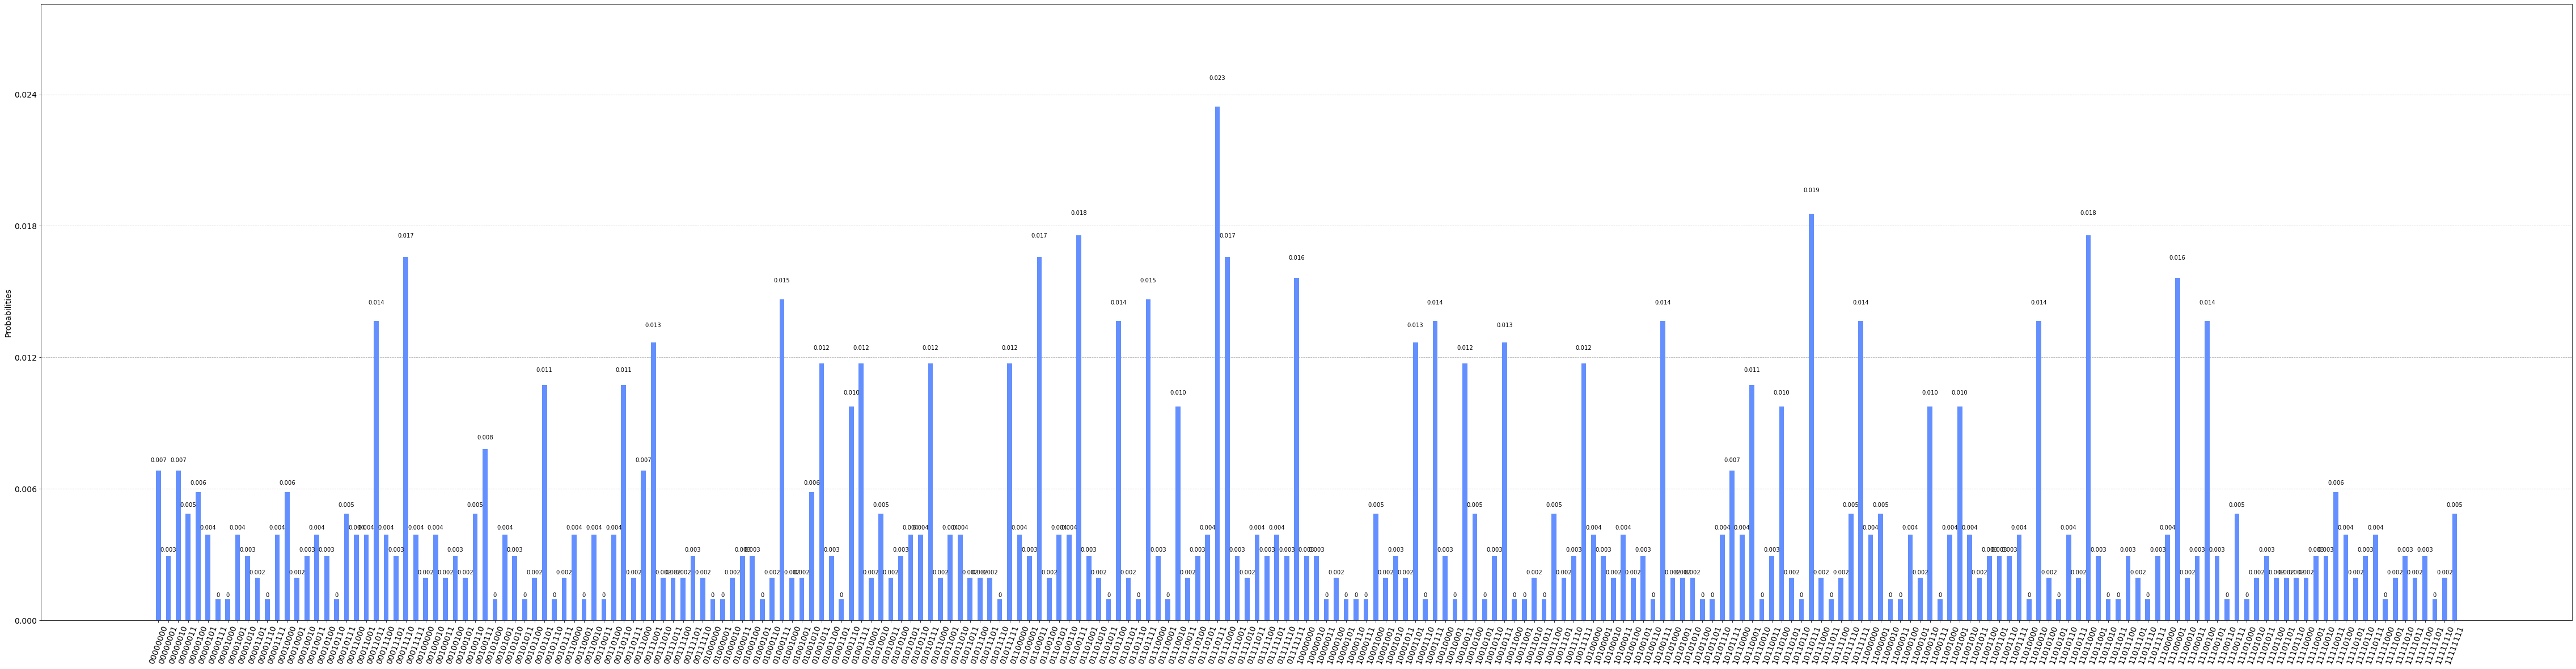

In [69]:
# Simulate and plot results
aer_simulator = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_simulator)
qobj = assemble(transpiled_qc)
result = aer_simulator.run(qobj).result()
plot_histogram(result.get_counts(), figsize = (80,20))